In [1]:
# Importer les libraires 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve

import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Importer le dataframe
df = pd.read_csv('df_consom_elec.csv')

# Importe les fonctions learning curve et validation curve

def learn_curve(model, x, y):
    from sklearn.model_selection import learning_curve
    l_curve, train_score, val_score = learning_curve(model,
                                                     x,
                                                     y,
                                                     train_sizes=np.linspace(0.1, 1.0, 10),
                                                     cv=5)
    plt.plot(l_curve, train_score.mean(axis=1), label='train')
    plt.plot(l_curve, val_score.mean(axis=1), label='validation')
    plt.ylabel('Score')
    plt.xlabel("Nombre d'échantillons du dataframe")
    plt.legend()
    return

def val_curve(model, x, y, para_name, para_range):
    param_range = para_range
    train_scores, test_scores = validation_curve(model,
                                             x,
                                             y,
                                             param_name=para_name,
                                             param_range=param_range,
                                             cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Validation Curve")
    plt.xlabel("Paramètres de l'hyperparamètre")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.2,
                     color="darkorange",
                     lw=lw)
    plt.semilogx(param_range, 
                 test_scores_mean, 
                 label="Cross-validation score", 
                 color="navy", lw=lw)
    plt.fill_between(param_range,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.2,
                     color="navy",
                     lw=lw)
    plt.legend(loc="best")
    plt.show()
    return

In [2]:
# Affiche les versions qui seront sauvergardées dans un fichier requirements.txt
print('Version de Numpy:', np.__version__)
print('Version de Pandas:', pd.__version__)
print('Version de SKLearn:', sk.__version__)
print('Version de Joblib:', joblib.__version__)
print('Version de Seaborn:', sns.__version__)

#pd.show_versions()

Version de Numpy: 1.20.1
Version de Pandas: 1.2.4
Version de SKLearn: 1.0.2
Version de Joblib: 1.0.1
Version de Seaborn: 0.10.1


## 1. PREPROCESSING

## Vérification du dataframe

In [3]:
# Nombres de valeurs manquantes des variables cible 
print("Nombre de valeurs manquantes de la variable cible 'SiteEnergyUse(kBtu)':", pd.isna(df['SiteEnergyUse(kBtu)']).sum())
print("Nombre de valeurs manquantes de la variable cible 'TotalGHGEmissions':", pd.isna(df['TotalGHGEmissions']).sum())

Nombre de valeurs manquantes de la variable cible 'SiteEnergyUse(kBtu)': 0
Nombre de valeurs manquantes de la variable cible 'TotalGHGEmissions': 0


In [4]:
# Vérification que les uint8 ont bien été convertis en float sur le nouveau notebook
df.dtypes[df.dtypes != 'float64']

PropertyGFATotal               int64
PropertyGFABuilding(s)         int64
Electricity_in_bat             int64
Gas_in_bat                     int64
Steam_in_bat                   int64
Year_of_reference              int64
Campus                         int64
NonResidential                 int64
Nonresidential COS             int64
Nonresidential WA              int64
SPS-District K-12              int64
College/University             int64
Distribution Center            int64
Distribution Center\n          int64
Hospital                       int64
Hotel                          int64
K-12 School                    int64
Laboratory                     int64
Large Office                   int64
Low-Rise Multifamily           int64
Medical Office                 int64
Mixed Use Property             int64
Non-Refrigerated Warehouse     int64
Office                         int64
Other                          int64
Refrigerated Warehouse         int64
Residence Hall                 int64
R

## Train_test_split

In [5]:
y_energy = df['SiteEnergyUse(kBtu)']
y_emission = df['TotalGHGEmissions']
x = df.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'],axis = 1)

X_train, X_test, y_emission_train, y_emission_test = train_test_split(x, y_emission, test_size = 0.2)

# Récupèration des index des Series créées
index_train = X_train.index
index_test = X_test.index

# Création des test et train sets en utilisant les index issus du split
y_energy_test = y_energy[index_test]
y_energy_train = y_energy[index_train]

print('Dimensions du train set :', X_train.shape)
print('Dimensions du test set :', X_test.shape)
print('Dimensions du train set de la target:', y_energy_train.shape)
print('Dimensions du test set de la target:',  y_energy_test.shape)

Dimensions du train set : (2606, 117)
Dimensions du test set : (652, 117)
Dimensions du train set de la target: (2606,)
Dimensions du test set de la target: (652,)


# Tranformation Gaussienne

- Certains modèles supposent que les fonctionnalités sont normalement distribuées et fonctionnerons mieux si les fonctionnalités qui leur sont fournies lors de la modélisation sont normalement distribuées.
- Les 2 features cibles ont des distributions positives et non normales.
- Nous allons donc appliquer 2 fonctions pour transformer les données et leur donnerune distribution normale

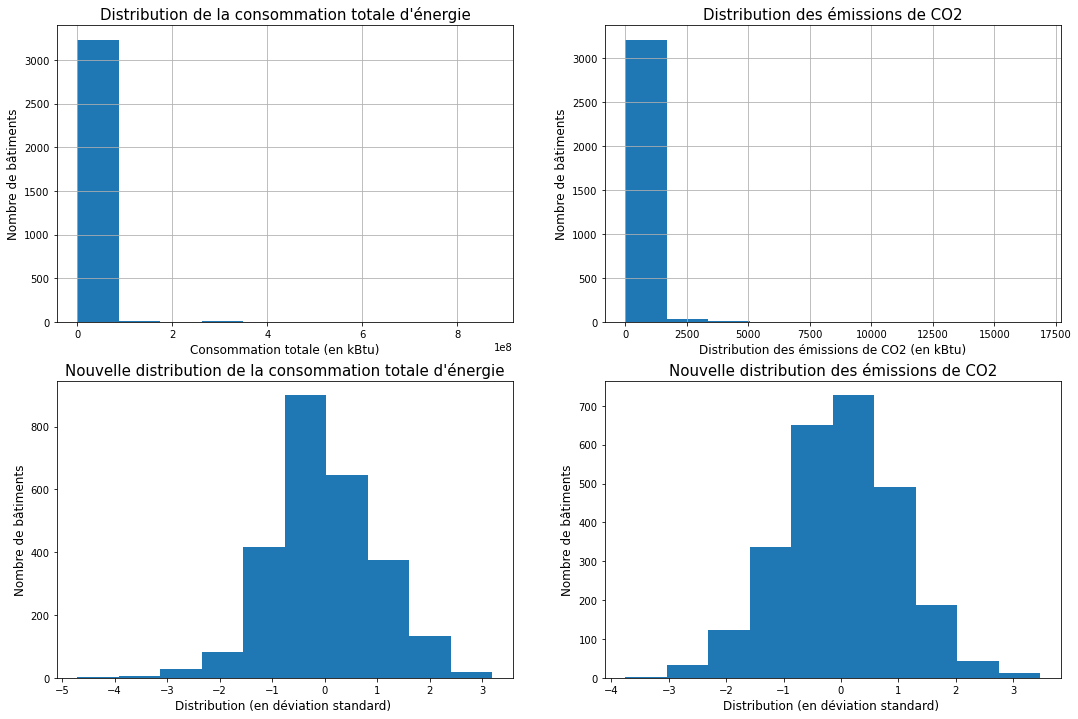

In [6]:
plt.figure(figsize=(18, 12))

# Transformation gaussienne de la feature basée sur la consommation d'énergie
plt.subplot(2, 2, 1)
y_energy.hist()

plt.title("Distribution de la consommation totale d'énergie", fontsize=15) 
plt.xlabel('Consommation totale (en kBtu)', fontsize=12) 
plt.ylabel('Nombre de bâtiments', fontsize=12) 

# Transformation gaussienne de la feature basée sur les émissions d'énergie
plt.subplot(2, 2, 2)
y_emission.hist()

plt.title("Distribution des émissions de CO2", fontsize=15 ) 
plt.xlabel('Distribution des émissions de CO2 (en kBtu)', fontsize= 12) 
plt.ylabel('Nombre de bâtiments', fontsize=12) 

 # Utilisation du transformer avec boxcox pour éviter une division par 0
plt.subplot(2, 2, 3)
pt = PowerTransformer(method='box-cox')
# On entraîne pt sur le train et on l'applique
# Le transformer a besoin d'un array numpy donc on transforme la Serie en array avec .value
# On reshape l'array pour avoir une feature et tous les samples avec .reshape(-1, 1)
y_energy_train_norm = pt.fit_transform(y_energy_train.values.reshape(-1, 1)) 

plt.hist(y_energy_train_norm)
plt.title("Nouvelle distribution de la consommation totale d'énergie", fontsize=15) 
plt.xlabel('Distribution (en déviation standard) ', fontsize=12) 
plt.ylabel('Nombre de bâtiments', fontsize=12) 


# Utilisation de la méthode yeo-johnson car la méthode box-cox n'acceptaient pas les valeurs négatives 
plt.subplot(2, 2, 4)

pt2 = PowerTransformer(method='yeo-johnson')
y_emission_train_norm = pt2.fit_transform(y_emission_train.values.reshape(-1, 1)) 
plt.hist(y_emission_train_norm)

plt.title('Nouvelle distribution des émissions de CO2', fontsize=15) 
plt.xlabel('Distribution (en déviation standard) ', fontsize=12) 
plt.ylabel('Nombre de bâtiments', fontsize=12) 

plt.show()

In [7]:
# Application de la transformation sur le test set
y_energy_test_norm = pt.transform(y_energy_test.values.reshape(-1, 1)) 
y_emission_test_norm = pt2.transform(y_emission_test.values.reshape(-1, 1)) 

# Imputation des NAN

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

## 2. MODELISATION AVEC COMME TARGET 'SiteEnergyUse(kBtu)'

- Nous allons créer un benchmark (Dummy Regressor)
- Nous testerons différents modèles de regression : Ridge, Lasso, SVM et Random Forest
- Nous utiliserons la Cross Validation pour tester les modèles sur différentes sections du dataset.
- Enfin, GridSearchCV (ou RandomSearchCV pour le SVR) nous permettra d'optimiser les hypersparamètres.

## Dummy regressor

In [9]:
# Utilisation d'un Dummy Regressor utilisé comme benchmark pour les modèles

dummy_mean = DummyRegressor(strategy = 'median').fit(X_train_imp, y_energy_train_norm)

print('Train Score pour dummy training:', dummy_mean.score(X_train_imp, y_energy_train_norm))
print('Test Score pour dummy training:', dummy_mean.score(X_test_imp, y_energy_test_norm))

Train Score pour dummy training: -0.006396357937351382
Test Score pour dummy training: -0.02748053613055612


## PIPELINE AVEC GRID SEARCH CV

In [10]:
# Initialise les estimateurs (algorithmes de regression)
reg1 = Ridge()
reg2 = Lasso()
reg3 = SVR()
reg4 = RandomForestRegressor()

# Création des pipelines
pipeline_rid = Pipeline([('scale', StandardScaler()),
                        ('regressor', reg1)]
                       )

pipeline_las = Pipeline([('scale', StandardScaler()),
                         ('regressor', reg2)]
                       )

pipeline_svr = Pipeline([('scale', StandardScaler()),
                         ('regressor', reg3)]
                       )

pipeline_rf =Pipeline([('scale',StandardScaler()),
                         ('regressor', reg4)]
                     )

# Variables des hyperparamètres 
param1 = {
    'regressor__alpha': np.logspace(-2, 2, 20)
         }

param2 = {
    'regressor__alpha': np.logspace(-5, -1, 20)
         }

param3 = {
    'regressor__C' : np.logspace(-2, 4, 10),
    'regressor__kernel': ['linear', 'poly', 'rbf'],
    'regressor__gamma': np.logspace(-4, 0, 5)
         }

param4 = {
    'regressor__max_features' : ["auto", "sqrt", "log2"],
    'regressor__min_samples_split' : [2, 4, 8],
    'regressor__bootstrap' : [True, False],
    'regressor__min_samples_leaf' : [0.1, 0.25, 0.5, 1],
    'regressor__max_depth' : [0.1, 0.25, 0.5, 1]
         }

## Ridge Regressor

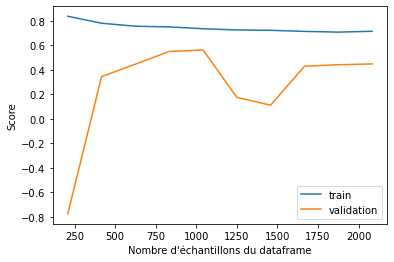

In [11]:
# Learning curve
learn_curve(Ridge(), X_train_imp, y_energy_train_norm)

In [12]:
grid_ridge = GridSearchCV(estimator=pipeline_rid,
                          param_grid=param1,
                          scoring='r2',
                          cv=5)

start_grid = time.time()
grid_ridge.fit(X_train_imp, y_energy_train_norm)
stop_grid = time.time()

vitesse_ridge_grid = stop_grid-start_grid
print("Durée de pour l'optimisation (en sec): ", vitesse_ridge_grid)

Durée de pour l'optimisation (en sec):  1.0120019912719727


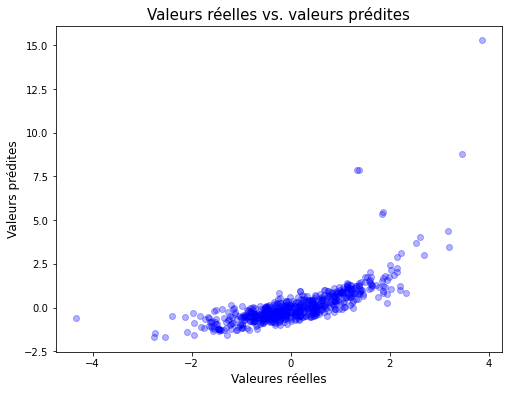

In [13]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred = grid_ridge.predict(X_test_imp)
plt.scatter(y_energy_test_norm, y_pred, color='blue', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [14]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_ridge.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_ridge.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__alpha': 100.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.008600,0.001020,0.000799,0.000400,100.0,{'regressor__alpha': 100.0},0.600580,0.175770,0.623434,0.629849,0.682294,0.542385,0.185249,1
18,0.007999,0.000631,0.000400,0.000490,61.584821,{'regressor__alpha': 61.584821106602604},0.595150,0.058606,0.621174,0.629467,0.682616,0.517403,0.231154,2
17,0.008402,0.000800,0.000999,0.000001,37.926902,{'regressor__alpha': 37.92690190732246},0.590981,-0.031575,0.619633,0.628557,0.682480,0.498015,0.266446,3
16,0.007401,0.001020,0.000600,0.000490,23.357215,{'regressor__alpha': 23.357214690901213},0.587930,-0.095782,0.618670,0.627408,0.682149,0.484075,0.291518,4
15,0.007600,0.000800,0.000800,0.000400,14.384499,{'regressor__alpha': 14.38449888287663},0.585789,-0.139026,0.618087,0.626220,0.681781,0.474570,0.308351,5


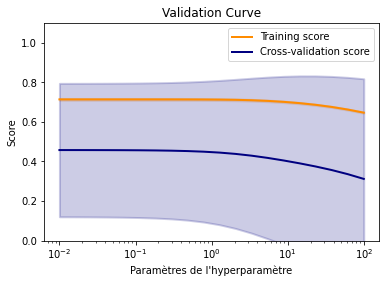

In [15]:
# Validation curve
val_curve(Ridge(),
          X_train_imp,
          y_energy_train_norm,
          "alpha",
          np.logspace(-2, 2, 20))

#### Métriques

In [16]:
# Moyenne d'une cross validation avec comme score mean_squared_error (MSE)
mse_mean_ridge = cross_val_score(grid_ridge, 
                                 X_train_imp, 
                                 y_energy_train_norm, 
                                 cv =5, 
                                 scoring='neg_mean_squared_error').mean()

mse_mean_ridge_pos = -1*mse_mean_ridge # Rendre le résultat positif

# Root Mean Squared Error (RMSE)
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_energy_test_norm, 
                                                y_pred)
                    )

# Moyenne d'une cross validation avec comme score mean_absolute_error (MAE)
mae_mean_ridge = cross_val_score(grid_ridge, 
                                 X_train_imp, 
                                 y_energy_train_norm, 
                                 cv =5, 
                                 scoring='neg_mean_absolute_error').mean()

mae_mean_ridge_pos = -1*mae_mean_ridge # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_ridge = cross_val_score(grid_ridge, 
                                   X_train_imp, 
                                   y_energy_train_norm, 
                                   cv =5, 
                                   scoring='neg_median_absolute_error').mean()

medae_mean_ridge_pos = -1*medae_mean_ridge # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_ridge = cross_val_score(grid_ridge, 
                           X_train_imp, 
                           y_energy_train_norm, 
                           cv =5, 
                           scoring='r2').mean()

# Test score après optimisation
score_ridge =  grid_ridge.score(X_test_imp, 
                                y_energy_test_norm)

print('MSE :', mse_mean_ridge_pos)
print("RMSE :", rmse_ridge)
print('MAE (Mean Absolute Error) :', mae_mean_ridge_pos)
print('MedAE (Median Absolute Error) :', medae_mean_ridge_pos)
print('R2 :', r2_ridge)
print('Test score après optimisation:', score_ridge)

MSE : 0.45969930119786795
RMSE : 0.8276045129324033
MAE (Mean Absolute Error) : 0.4329617066861515
MedAE (Median Absolute Error) : 0.32608319199076835
R2 : 0.5423852006104273
Test score après optimisation: 0.2727424383592151


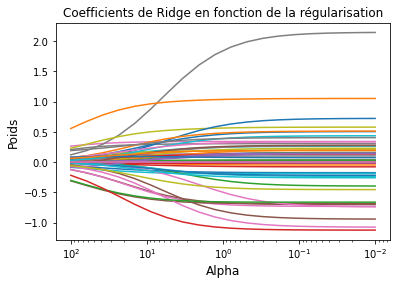

In [17]:
# Chemins de regularisation pour observer l'évolution des coefficients en fonction des valeurs alpha durant la GridSearchCV

# Calculer les chemins
ridge = Ridge()

n_alphas = 20
alphas = np.logspace(-2, 2, n_alphas)

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_imp, y_energy_train_norm)
    coefs.append(ridge.coef_)
    errors.append(np.mean((ridge.predict(X_test_imp) - y_energy_test_norm) ** 2))
    
# Création d'un numpy array à deux dimmension pour le plot
coefs = np.array(coefs).reshape(n_alphas, -1)

# Visualise les chemins
plt.figure(figsize=(6, 4))

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # renverse les axes

plt.title('Coefficients de Ridge en fonction de la régularisation', fontsize=12)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('Poids', fontsize=12)

plt.show()

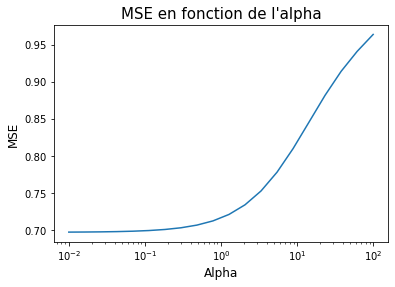

In [18]:
plt.figure(figsize=(6, 4))

ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')

plt.title("MSE en fonction de l'alpha", fontsize=15)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.show()

### On constate qu'à partir d'un alpha de 10, le MSE augmente exponentiellement.

## Lasso Regressor

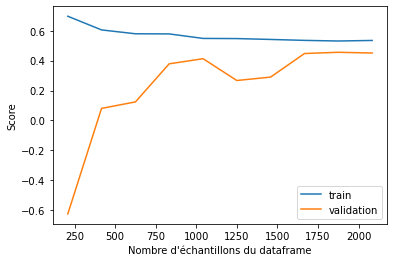

In [19]:
# Learning curve
learn_curve(Lasso(), X_train_imp, y_energy_train_norm)

- Une fois le seuil de 750 échantillons atteint, on constate que le score n'augmente plus.
- Le temps de calcul n'étant pas important, nous allons utiliser tout le train set

In [20]:
grid_lasso = GridSearchCV(estimator=pipeline_las,
                          param_grid=param2,
                          scoring='r2',
                          cv=5)

start_grid2 = time.time()
grid_lasso.fit(X_train_imp, y_energy_train_norm)
stop_grid2 = time.time()

vitesse_lasso_grid = stop_grid2-start_grid2
print("Durée de pour l'optimisation (en sec):", vitesse_lasso_grid)

Durée de pour l'optimisation (en sec): 9.362998008728027


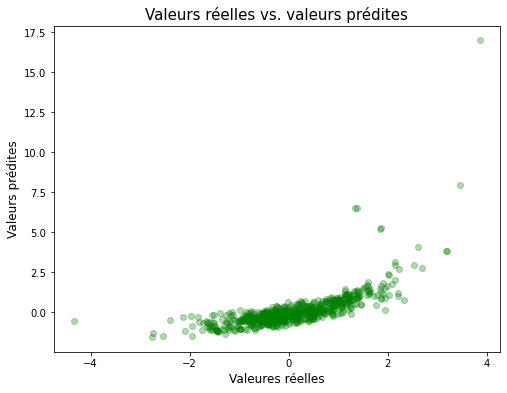

In [21]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred2 = grid_lasso.predict(X_test_imp)
plt.scatter(y_energy_test_norm, y_pred2, color='green', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [22]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_lasso.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_lasso.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__alpha': 0.01438449888287663}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.024399,0.005818,0.001201,4.000429e-04,0.014384,{'regressor__alpha': 0.01438449888287663},0.630400,0.660335,0.637235,0.633667,0.673048,0.646937,0.016763,1
14,0.025198,0.008085,0.001001,7.893059e-07,0.008859,{'regressor__alpha': 0.008858667904100823},0.625021,0.601194,0.641081,0.643207,0.682069,0.638514,0.026459,2
16,0.021800,0.004621,0.001000,1.497299e-06,0.023357,{'regressor__alpha': 0.023357214690901212},0.630748,0.638887,0.626330,0.615759,0.655463,0.633437,0.013305,3
17,0.026402,0.002799,0.001198,3.990417e-04,0.037927,{'regressor__alpha': 0.03792690190732246},0.624605,0.604191,0.605124,0.586513,0.629588,0.610004,0.015532,4
13,0.025394,0.007300,0.000999,2.096999e-06,0.005456,{'regressor__alpha': 0.005455594781168515},0.617351,0.431370,0.637465,0.647191,0.685853,0.603846,0.089067,5


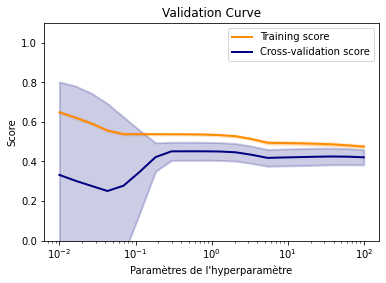

In [23]:
# Validation curve
val_curve(Lasso(),
          X_train_imp,
          y_energy_train_norm,
          "alpha",
          np.logspace(-2, 2, 20))

#### Métriques

In [24]:
# Moyenne d'une cross validation avec comme score mean_squared_error (MSE)
mse_mean_lasso = cross_val_score(grid_lasso, 
                                 X_train_imp, 
                                 y_energy_train_norm, 
                                 cv =5, 
                                 scoring='neg_mean_squared_error').mean()

mse_mean_lasso_pos = -1*mse_mean_lasso # Rendre le résultat positif

# Root Mean Squared Error (RMSE)
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_energy_test_norm,
                                                y_pred)
                    )

# Moyenne d'une cross validation avec comme score mean_absolute_error (MAE)
mae_mean_lasso = cross_val_score(grid_lasso,
                                 X_train_imp,
                                 y_energy_train_norm, 
                                 cv =5, 
                                 scoring='neg_mean_absolute_error').mean()

mae_mean_lasso_pos = -1*mae_mean_lasso # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_lasso = cross_val_score(grid_lasso, 
                                   X_train_imp, 
                                   y_energy_train_norm, 
                                   cv =5, 
                                   scoring='neg_median_absolute_error').mean()

medae_mean_lasso_pos = -1*medae_mean_lasso # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_lasso = cross_val_score(grid_lasso, 
                           X_train_imp, 
                           y_energy_train_norm,
                           cv =5, 
                           scoring='r2').mean()

# Test score après optimisation
score_lasso =  grid_lasso.score(X_test_imp, 
                                y_energy_test_norm)

print('MSE :', mse_mean_lasso_pos)
print("RMSE :", rmse_lasso)
print('MAE (Mean Absolute Error) :', mae_mean_lasso_pos)
print('MedAE (Median Absolute Error) :', medae_mean_lasso_pos)
print('R2 :', r2_lasso)
print('Test score après optimisation:', score_lasso)

MSE : 0.3592814743340407
RMSE : 0.8276045129324033
MAE (Mean Absolute Error) : 0.4449764025539313
MedAE (Median Absolute Error) : 0.3532449171973004
R2 : 0.6405359438640549
Test score après optimisation: 0.25773388900486804


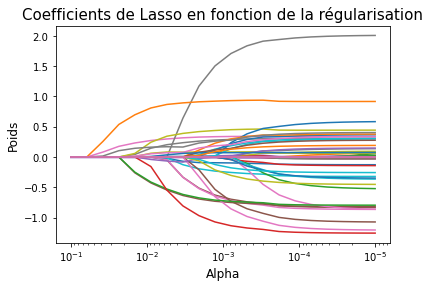

In [25]:
# Chemins de regularisation pour observer l'évolution des coefficients en fonction des valeurs alpha durant la GridSearchCV

# Calculer les chemins
lasso = Lasso(max_iter=5000)

n_alphas = 20
alphas = np.logspace(-5, -1, n_alphas)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_imp, y_energy_train_norm)
    coefs.append(lasso.coef_)
    errors.append(np.mean((lasso.predict(X_test_imp) - y_energy_test_norm) ** 2))
    
# On recrée un array numpy à deux dimmension pour le plot
coefs = np.array(coefs).reshape(n_alphas, -1)

# Afficher les chemins
plt.figure(figsize=(6, 4))

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])   # renverse les axes

plt.title('Coefficients de Lasso en fonction de la régularisation', fontsize=15)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('Poids', fontsize=12)

plt.show()

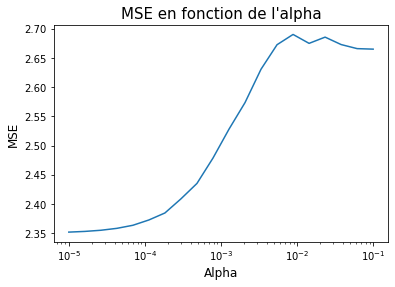

In [26]:
plt.figure(figsize=(6, 4))

ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')

plt.title("MSE en fonction de l'alpha", fontsize=15)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.show()

#### On constate que la MSE diminue fortement lorsque l'alpha dépasse 0.0001

# Support Vector Regression

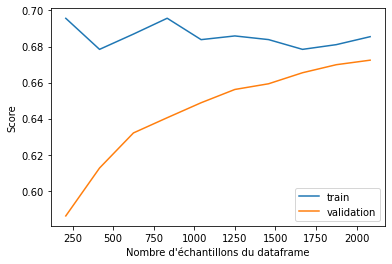

In [27]:
# Learning curve
learn_curve(SVR(), X_train_imp, y_energy_train_norm)

- A partir de 1500 échantillons l'augmentation du score est moins importante.
- Nous utiliserons 1500 échantillons pour limiter le temps de calcul.
- RandomisezSearchCV sera utilisé pour également limiter le temps de calcul.
- Le nom "grid" reste utilisé pour avoir une continuité entre les différents modèles.

In [28]:
grid_svr = GridSearchCV(estimator=pipeline_svr,
                        param_grid=param3,
                        scoring='r2',
                        cv=5)

start_grid3 = time.time()
grid_svr.fit(X_train_imp[:100], y_energy_train_norm[:100])
stop_grid3 = time.time()

vitesse_svr_grid = stop_grid3-start_grid3
print("Durée de pour l'optimisation (en sec):", vitesse_svr_grid)

Durée de pour l'optimisation (en sec): 3218.8743331432343


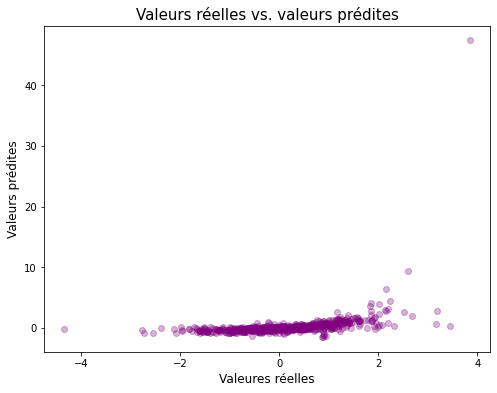

In [29]:
# Application du modele sur le test set

plt.figure(figsize=(8,6))
y_pred3 = grid_svr.predict(X_test_imp)
plt.scatter(y_energy_test_norm, y_pred3, color='purple', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [30]:
# Afficher les hyperparamètres optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_svr.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_svr.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__C': 0.01, 'regressor__gamma': 0.0001, 'regressor__kernel': 'linear'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__C,param_regressor__gamma,param_regressor__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001793,0.000747,0.000407,0.000498,0.01,0.0001,linear,"{'regressor__C': 0.01, 'regressor__gamma': 0.0...",0.671098,0.773085,0.119388,0.429115,0.315028,0.461543,0.23688,1
9,0.001599,0.000491,0.000399,0.000489,0.01,0.1,linear,"{'regressor__C': 0.01, 'regressor__gamma': 0.1...",0.671098,0.773085,0.119388,0.429115,0.315028,0.461543,0.23688,1
3,0.002207,0.000756,0.001000,0.000001,0.01,0.001,linear,"{'regressor__C': 0.01, 'regressor__gamma': 0.0...",0.671098,0.773085,0.119388,0.429115,0.315028,0.461543,0.23688,1
12,0.001807,0.000405,0.000800,0.000400,0.01,1.0,linear,"{'regressor__C': 0.01, 'regressor__gamma': 1.0...",0.671098,0.773085,0.119388,0.429115,0.315028,0.461543,0.23688,1
6,0.001392,0.000481,0.000600,0.000490,0.01,0.01,linear,"{'regressor__C': 0.01, 'regressor__gamma': 0.0...",0.671098,0.773085,0.119388,0.429115,0.315028,0.461543,0.23688,1


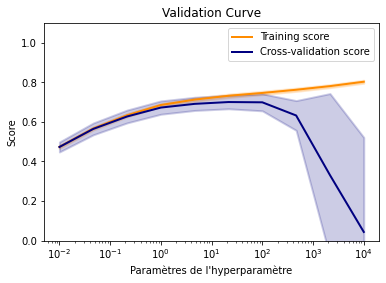

In [31]:
# Validation curve pour l'hyperparamètre 'C'
val_curve(SVR(),
          X_train_imp,
          y_energy_train_norm,
         'C',
          np.logspace(-2, 4, 10))

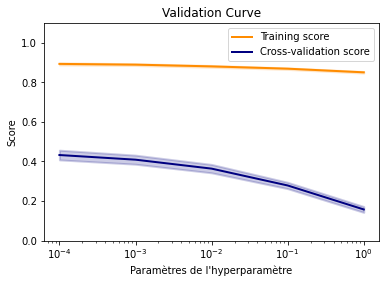

In [32]:
# Validation curve pour l'hyperparamètre 'gamma'
val_curve(SVR(),
          X_train_imp,
          y_energy_train_norm,
         'gamma',
          np.logspace(-4, 0, 5))

#### Métriques

In [33]:
# Modèles avec les meilleurs hyperparamètres
svr = SVR(C=4.6415888336127775,
         gamma=0.01,
         kernel='rbf')


# Moyenne d'une cross validation avec comme score mean_squared_error (MSE)
mse_mean_svr = cross_val_score(svr,
                               X_train_imp, 
                               y_energy_train_norm.ravel(), 
                               cv =5,
                               scoring='neg_mean_squared_error').mean()

mse_mean_svr_pos = -1*mse_mean_svr # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MSE)
mse_mean_svr = cross_val_score(svr,
                               X_train_imp, 
                               y_energy_train_norm.ravel(), 
                               cv =5,
                               scoring='neg_mean_squared_error').mean()

mse_mean_svr_pos = -1*mse_mean_svr # Rendre le résultat positif

# Root Mean Squared Error (RMSE)
rmse_svr = np.sqrt(metrics.mean_squared_error(y_energy_test_norm, 
                                              y_pred)
                  )

# Moyenne d'une cross validation avec comme score mean_absolute_error (MAE)
mae_mean_svr = cross_val_score(svr,
                               X_train_imp,
                               y_energy_train_norm.ravel(), 
                               cv =5, 
                               scoring='neg_mean_absolute_error').mean()

mae_mean_svr_pos = -1*mae_mean_svr # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_svr = cross_val_score(svr, 
                                 X_train_imp, 
                                 y_energy_train_norm.ravel(), 
                                 cv =5, 
                                 scoring='neg_median_absolute_error').mean()


medae_mean_svr_pos = -1*medae_mean_svr # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_svr = cross_val_score(svr,
                         X_train_imp, 
                         y_energy_train_norm.ravel(), 
                         cv =5, 
                         scoring='r2').mean()

# Test score après optimisation
score_svr = grid_svr.score(X_test_imp,
                           y_energy_test_norm)

print('MSE :', mse_mean_svr_pos)
print("RMSE :", rmse_svr)
print('MAE (Mean Absolute Error) :', mae_mean_svr_pos)
print('MedAE (Median Absolute Error) :', medae_mean_svr_pos)
print('R2 :', r2_svr)
print('Test score après optimisation:', score_svr)

MSE : 0.5697380000360577
RMSE : 0.8276045129324033
MAE (Mean Absolute Error) : 0.49522536274917933
MedAE (Median Absolute Error) : 0.24111961640528418
R2 : 0.4300831599459597
Test score après optimisation: -2.73194562541909


# Random Forest Regressor

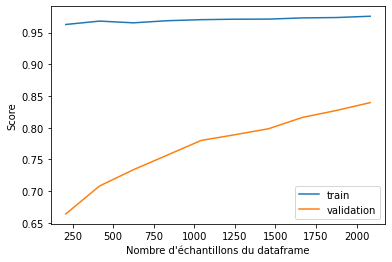

In [34]:
# Learning curve
learn_curve(RandomForestRegressor(), X_train_imp, y_energy_train_norm)

In [35]:
grid_rfreg = GridSearchCV(estimator=pipeline_rf,
                          param_grid=param4,
                          scoring='r2',
                          cv=5)

start_grid4 = time.time()
grid_rfreg.fit(X_train_imp, y_energy_train_norm.ravel())
stop_grid4 = time.time()

vitesse_rf_grid = stop_grid4-start_grid4
print("Temps pour l'optimisation:", vitesse_rf_grid)

Temps pour l'optimisation: 149.1848340034485


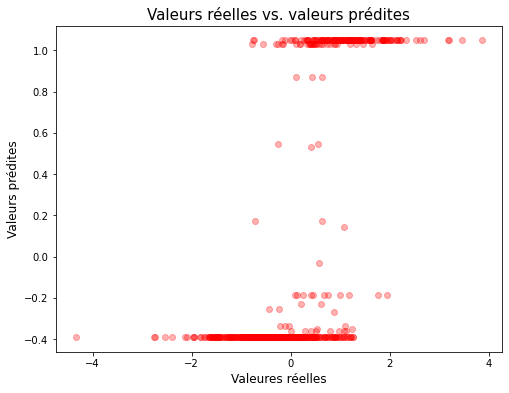

In [36]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred4 = grid_rfreg.predict(X_test_imp)
plt.scatter(y_energy_test_norm, y_pred4, color='red', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [37]:
# Afficher les hyperparamètres optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_rfreg.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_rfreg.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__bootstrap': True, 'regressor__max_depth': 1, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 8}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__max_depth,param_regressor__max_features,param_regressor__min_samples_leaf,param_regressor__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
119,0.218157,0.004786,0.008398,0.000492,True,1,auto,1,8,"{'regressor__bootstrap': True, 'regressor__max...",0.453428,0.421218,0.426895,0.390888,0.427169,0.423920,0.019943,1
110,0.261390,0.026512,0.010600,0.001960,True,1,auto,0.1,8,"{'regressor__bootstrap': True, 'regressor__max...",0.454153,0.417382,0.422056,0.391819,0.428574,0.422797,0.020030,2
109,0.209161,0.005153,0.007805,0.000741,True,1,auto,0.1,4,"{'regressor__bootstrap': True, 'regressor__max...",0.452731,0.411297,0.429356,0.392774,0.426638,0.422559,0.019936,3
117,0.216881,0.004959,0.008203,0.000387,True,1,auto,1,2,"{'regressor__bootstrap': True, 'regressor__max...",0.455594,0.413609,0.425040,0.391754,0.424585,0.422116,0.020638,4
108,0.232610,0.016245,0.009595,0.002244,True,1,auto,0.1,2,"{'regressor__bootstrap': True, 'regressor__max...",0.453530,0.416703,0.420652,0.391728,0.426686,0.421860,0.019810,5


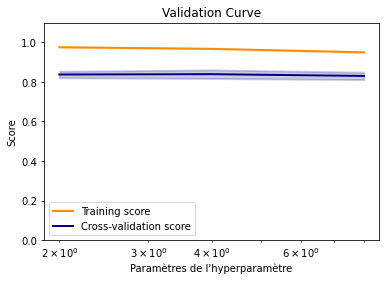

In [38]:
# Validation curve pour l'hyperparamètre 'min_samples_split'
val_curve(RandomForestRegressor(),
          X_train_imp,
          y_energy_train_norm,
          "min_samples_split",
          [2, 4, 8])

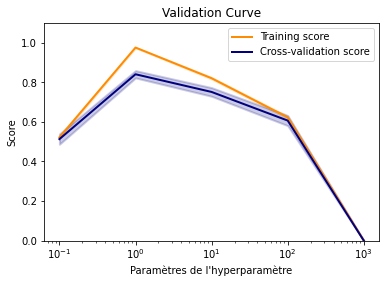

In [39]:
# Validation curve pour l'hyperparamètre 'min_samples_leaf'
val_curve(RandomForestRegressor(),
          X_train_imp,
          y_energy_train_norm,
          "min_samples_leaf",
          [0.1, 1, 10, 100, 1000])

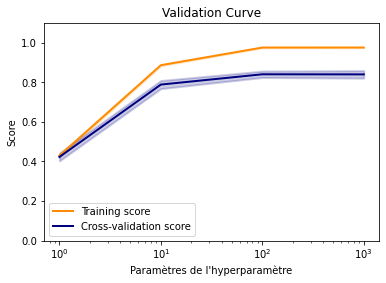

In [40]:
# Validation curve pour l'hyperparamètre 'max_depth'
val_curve(RandomForestRegressor(),
          X_train_imp,
          y_energy_train_norm,
          "max_depth",
          [1, 10, 100, 1000])

#### Métriques

In [41]:
rf = RandomForestRegressor(bootstrap=True,
                           max_depth=1,
                           max_features='auto', 
                           min_samples_leaf=0.1,
                           min_samples_split=8)

# Moyenne d'une cross validation avec comme score mean_squared_error (MSE)
mse_mean_rf = cross_val_score(rf, 
                              X_train_imp, 
                              y_energy_train_norm.ravel(), 
                              cv =5,
                              scoring='neg_mean_squared_error').mean()

mse_mean_rf_pos = -1*mse_mean_rf # Rendre le résultat positif

# Root Mean Squared Error (RMSE)
rmse_rf = np.sqrt(metrics.mean_squared_error(y_energy_test_norm,
                                             y_pred)
                 )

# Moyenne d'une cross validation avec comme score mean_absolute_error (MAE)
mae_mean_rf = cross_val_score(rf, X_train_imp,
                              y_energy_train_norm.ravel(),
                              cv =5, 
                              scoring='neg_mean_absolute_error').mean()

mae_mean_rf_pos = -1*mae_mean_rf # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_rf = cross_val_score(rf,
                                X_train_imp,
                                y_energy_train_norm.ravel(), 
                                cv =5, 
                                scoring='neg_median_absolute_error').mean()

medae_mean_rf_pos = -1*medae_mean_rf # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_rf = cross_val_score(rf,
                        X_train_imp, 
                        y_energy_train_norm.ravel(), 
                        cv =5, 
                        scoring='r2').mean()

# Test score après optimisation
score_rf = grid_rfreg.score(X_test_imp, 
                            y_energy_test_norm )

print('MSE :', mse_mean_rf_pos)
print("RMSE :", rmse_rf)
print('MAE (Mean Absolute Error) :', mae_mean_rf_pos)
print('MedAE (Median Absolute Error) :', medae_mean_rf_pos)
print('R2 :', r2_rf)
print('Test score après optimisation:', score_rf)

MSE : 0.5752119794095536
RMSE : 0.8276045129324033
MAE (Mean Absolute Error) : 0.5715536875219669
MedAE (Median Absolute Error) : 0.42612439123182666
R2 : 0.4234843914290126
Test score après optimisation: 0.42163988983866774


L'optimisation n'a pas permis de gagner en précision donc on peut garder les hyper-paramètres définis par défaut.

Le meilleur score R2 pour Random Forrest Regressor : 0.853 avec les hyperparamètres initiaux.

## Comparaison des métriques pour les différents modèles 

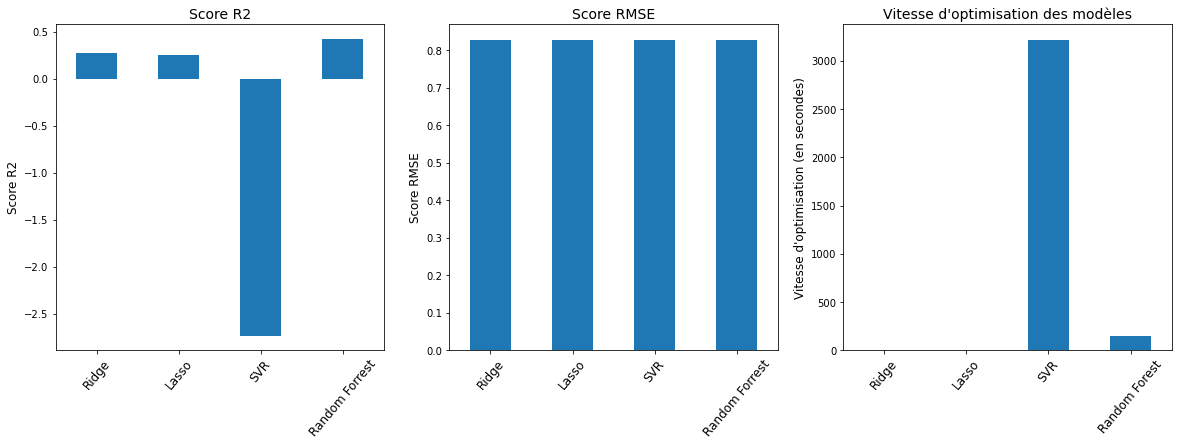

In [42]:
plt.figure(figsize=(20,6))

# Score R2
plt.subplot(1, 3, 1)
score_model = pd.Series([score_ridge, score_lasso, score_svr, score_rf], 
                        index=["Ridge", "Lasso", "SVR", 
                               "Random Forrest"])
score_model.plot.bar()
plt.title("Score R2", fontsize=14)
plt.ylabel('Score R2', fontsize=12)
degrees = 50
plt.xticks(rotation=degrees, fontsize=12)

# RMSE
plt.subplot(1, 3, 2)
rmse_model = pd.Series([rmse_ridge, rmse_lasso, rmse_svr, rmse_rf], 
                          index=["Ridge", "Lasso", "SVR",
                                 "Random Forrest"])
rmse_model.plot.bar()
plt.title("Score RMSE", fontsize=14)
plt.ylabel("Score RMSE", fontsize=12)
degrees = 50
plt.xticks(rotation=degrees, fontsize=12)

# Vitesse d'optimisation
plt.subplot(1, 3, 3)
vitesse_model_optimisation = pd.Series([vitesse_ridge_grid, vitesse_lasso_grid, vitesse_svr_grid, 
                                        vitesse_rf_grid], 
                                       index=["Ridge", "Lasso", "SVR",
                                              "Random Forest"])
vitesse_model_optimisation.plot.bar()
plt.title("Vitesse d'optimisation des modèles", fontsize=14)
plt.ylabel("Vitesse d'optimisation (en secondes)", fontsize=12)
degrees = 50
plt.xticks(rotation=degrees, fontsize=12)

plt.show()

Features les plus importantes du Random Forest

In [43]:
'''
df_rf = X_train.columns

df_features = pd.Series(rf.feature_importances_, index = df_rf)
df_features = df_features.sort_values()

plt.figure(figsize=(20,35))
plt.barh(df_rf, df_features)
plt.title('Importance des features pour le modèle Random Forest Regressor')
'''

Les 3 features les plus importantes sont :

- Hotel_GFA
- Bank Branch_GFA
- Data Center_GFA

## 3. MODELISATION AVEC COMME TARGET ''TotalGHGEmissions''

## Dummy regressor

In [45]:
# Utilisation d'un Dummy Regressor utilisé comme benchmark pour les modèles

dummy_mean_2 = DummyRegressor(strategy = 'median').fit(X_train_imp,  y_emission_train_norm)

print('Score for dummy training:', dummy_mean_2.score(X_train_imp, y_emission_train_norm))
print('Score for dummy training:', dummy_mean_2.score(X_test_imp, y_emission_test_norm))

Score for dummy training: -8.244107991139948e-05
Score for dummy training: -0.015560440941920106


In [46]:
X_train_imp.shape

(2606, 117)

In [47]:
y_emission_train_norm.shape

(2606, 1)

## Ridge Regressor

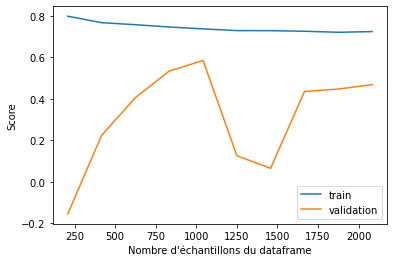

In [48]:
# Learning curve
learn_curve(Ridge(), X_train_imp, y_emission_train_norm)

In [53]:
grid_ridge2 = GridSearchCV(estimator=pipeline_rid,
                          param_grid=param1,
                          scoring='r2',
                          cv=5)

start_grid5 = time.time()
grid_ridge2.fit(X_train_imp, y_emission_train_norm)
stop_grid5 = time.time()

vitesse_ridge_grid2 = stop_grid5-start_grid5
print("Durée de pour l'optimisation (en sec): ", vitesse_ridge_grid2)

Durée de pour l'optimisation (en sec):  0.9568080902099609


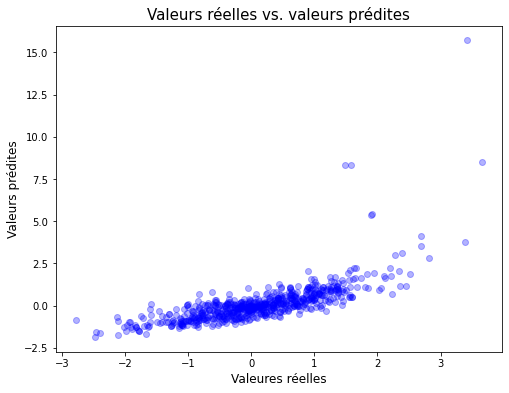

In [55]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred5 = grid_ridge2.predict(X_test_imp)
plt.scatter(y_emission_test_norm, y_pred5, color='blue', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [56]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_ridge2.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_ridge2.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__alpha': 100.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.007800,0.000748,0.001001,0.000633,100.0,{'regressor__alpha': 100.0},0.597003,0.235341,0.657625,0.618167,0.688353,0.559298,0.165020,1
18,0.009325,0.001763,0.001045,0.000344,61.584821,{'regressor__alpha': 61.584821106602604},0.592198,0.125088,0.656374,0.615683,0.688860,0.535641,0.207948,2
17,0.008601,0.001356,0.000800,0.000400,37.926902,{'regressor__alpha': 37.92690190732246},0.588417,0.040392,0.655425,0.613452,0.688527,0.517243,0.240890,3
16,0.007001,0.000001,0.000200,0.000400,23.357215,{'regressor__alpha': 23.357214690901213},0.585631,-0.019988,0.654800,0.611508,0.687823,0.503955,0.264317,4
15,0.007602,0.000490,0.000799,0.000399,14.384499,{'regressor__alpha': 14.38449888287663},0.583683,-0.060846,0.654414,0.609847,0.687055,0.494831,0.280113,5


#### Métriques

In [99]:
# Moyenne d'une cross validation avec comme score mean_squared_error
mse_mean_ridge2 = cross_val_score(grid_ridge2, 
                                  y_emission_test_norm, 
                                  y_pred5, 
                                  cv =5, 
                                  scoring='neg_mean_squared_error').mean()

# Rendre le résultat positif (de l'erreur quadratique moyenne negative à l'erreur quadratique moyenne positive )
mse_mean_ridge_pos2 = -1*mse_mean_ridge2

# Root Mean Squared Error (RMSE)
rmse_ridge2 = np.sqrt(metrics.mean_squared_error(y_emission_test_norm,
                                                 y_pred5)
                     )

# Moyenne d'une cross validation avec comme score mean_squared_error
mae_mean_ridge2 = cross_val_score(grid_ridge2,
                                  y_emission_test_norm,
                                  y_pred5, 
                                  cv =5, 
                                  scoring='neg_mean_absolute_error').mean()

mae_mean_ridge_pos2 = -1*mae_mean_ridge2 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_ridge2 = cross_val_score(grid_ridge2,
                                    X_train_imp, 
                                    y_emission_train_norm, 
                                    cv =5, 
                                    scoring='neg_median_absolute_error').mean()

medae_mean_ridge_pos2 = -1*medae_mean_ridge # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_ridge2 = cross_val_score(grid_ridge2,
                            y_emission_test_norm,
                            y_pred5, 
                            cv =5, 
                            scoring='r2').mean()

# Test score après optimisation
score_ridge2 =  grid_ridge2.score(X_test_imp, 
                                  y_emission_test_norm )

print('MSE :', mse_mean_ridge_pos2)
print("RMSE :", rmse_Ridge2)
print('MAE (Mean Absolute Error) :', mae_mean_ridge_pos2)
print('MedAE (Median Absolute Error) :', mae_mean_ridge_pos2)
print('R2 :', r2_ridge2)
print('Test score après optimisation:', score_Ridge2)

MSE : 0.7241782337919951


NameError: name 'rmse_Ridge2' is not defined

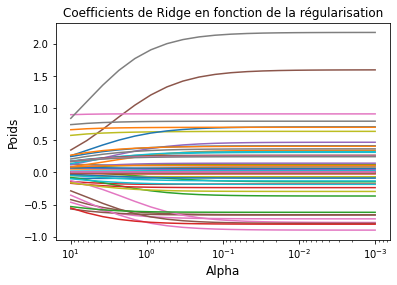

In [58]:
# Chemins de regularisation pour observer l'évolution des coefficients en fonction des valeurs alpha durant la GridSearchCV

# Calculer les chemins
ridge2 = Ridge()

n_alphas = 20
alphas = np.logspace(-3, 1, n_alphas)

coefs = []
errors = []
for a in alphas:
    ridge2.set_params(alpha=a)
    ridge2.fit(X_train_imp, y_emission_train_norm)
    coefs.append(ridge2.coef_)
    errors.append(np.mean((ridge2.predict(X_test_imp) - y_emission_test_norm) ** 2))
    
# Création d'un  array numpy à deux dimmension pour le plot
coefs = np.array(coefs).reshape(n_alphas, -1)

# Visualise les chemins
plt.figure(figsize=(6, 4))

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.title('Coefficients de Ridge en fonction de la régularisation', fontsize=12)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('Poids', fontsize=12)

plt.show()

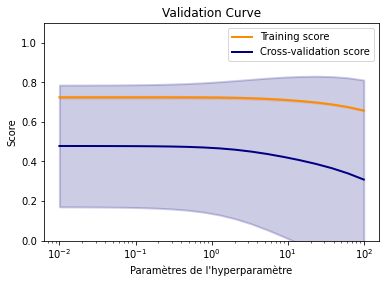

In [59]:
# Validation curve
val_curve(Ridge(),
          X_train_imp,
          y_emission_train_norm,
          "alpha",
          np.logspace(-2, 2, 20))

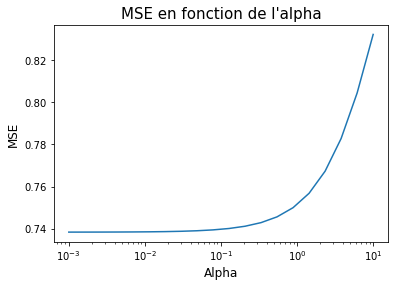

In [60]:
plt.figure(figsize=(6, 4))

ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')

plt.title("MSE en fonction de l'alpha", fontsize=15)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.show()

## Lasso Regressor

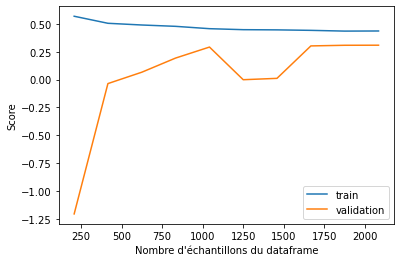

In [61]:
# Learning curve
learn_curve(Lasso(), X_train_imp, y_emission_train_norm)

In [62]:
grid_lasso2 = GridSearchCV(estimator=pipeline_las,
                          param_grid=param2,
                          scoring='r2',
                          cv=5)

start_grid6 = time.time()
grid_lasso2.fit(X_train_imp, y_emission_train_norm)
stop_grid6 = time.time()

vitesse_lasso_grid2 = stop_grid6-start_grid6
print("Durée de pour l'optimisation (en sec):", vitesse_lasso_grid2)

Durée de pour l'optimisation (en sec): 6.614159345626831


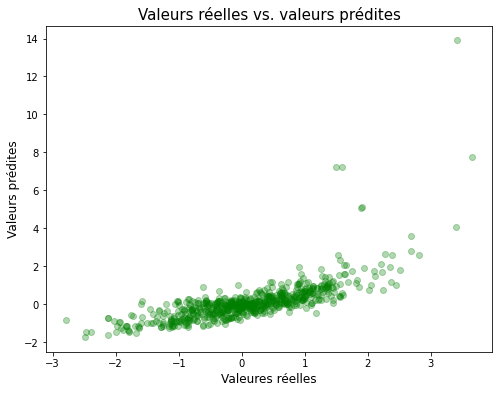

In [63]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred6 = grid_lasso2.predict(X_test_imp)
plt.scatter(y_emission_test_norm, y_pred6, color='green', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [64]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_lasso2.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_lasso2.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__alpha': 0.01438449888287663}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.023200,0.004069,0.001200,3.998999e-04,0.014384,{'regressor__alpha': 0.01438449888287663},0.616236,0.679823,0.662632,0.673448,0.666715,0.659771,0.022543,1
14,0.023399,0.004800,0.001001,1.293627e-06,0.008859,{'regressor__alpha': 0.008858667904100823},0.610330,0.628750,0.666618,0.675666,0.680080,0.652289,0.027708,2
16,0.022400,0.001019,0.001000,6.975526e-07,0.023357,{'regressor__alpha': 0.023357214690901212},0.624476,0.658851,0.653107,0.662441,0.645251,0.648825,0.013490,3
17,0.017711,0.001842,0.000800,3.998781e-04,0.037927,{'regressor__alpha': 0.03792690190732246},0.617745,0.627433,0.637600,0.637852,0.612830,0.626692,0.010161,4
13,0.021601,0.004924,0.000999,2.281854e-06,0.005456,{'regressor__alpha': 0.005455594781168515},0.604844,0.469153,0.665958,0.661052,0.686786,0.617558,0.079010,5


#### Métriques

In [100]:
# Moyenne d'une cross validation avec comme score mean_squared_error (MSE)
mse_mean_lasso2 = cross_val_score(grid_lasso2, 
                                  X_train_imp, 
                                  y_emission_train_norm, 
                                  cv =5, 
                                  scoring='neg_mean_squared_error').mean()

mse_mean_lasso_pos2 = -1*mse_mean_lasso2 # Rendre le résultat positif 

# Root Mean Squared Error (RMSE)
rmse_lasso2 = np.sqrt(metrics.mean_squared_error(y_emission_test_norm, 
                                                 y_pred6)
                     )

# Moyenne d'une cross validation avec comme score mean_absolute_error
mae_mean_lasso2 = cross_val_score(grid_lasso2,
                                  X_train_imp,
                                  y_emission_train_norm,
                                  cv =5, 
                                  scoring='neg_mean_absolute_error').mean()

mae_mean_lasso_pos2 = -1*mae_mean_lasso2 # Rendre le résultat positif

# Mediane d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_lasso2 = cross_val_score(grid_lasso2,
                                    X_train_imp,
                                    y_emission_train_norm, 
                                    cv =5, 
                                    scoring='neg_median_absolute_error').mean()

medae_mean_lasso_pos2 = -1*medae_mean_lasso2 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_lasso2 = cross_val_score(grid_lasso2, 
                            X_train_imp,
                            y_emission_train_norm, 
                            cv =5, 
                            scoring='r2').mean()

# Test score après optimisation
score_lasso2 =  grid_lasso2.score(X_test_imp,
                                  y_emission_test_norm)

print('MSE :', mse_mean_lasso_pos2)
print("RMSE :", rmse_lasso2)
print('MAE (Mean Absolute Error) :', mae_mean_lasso_pos2)
print('MedAE( Median Absolute Error) :', medae_mean_lasso_pos2)
print('R2 :', r2_lasso2)
print('Test score après optimisation:', score_lasso2)

MSE : 0.3429891420959216
RMSE : 0.7795738498620646
MAE (Mean Absolute Error) : 0.4567465651872758
MedAE( Median Absolute Error) : 0.3841623362132401
R2 : 0.6560201674275812
Test score après optimisation: 0.3405485281893821


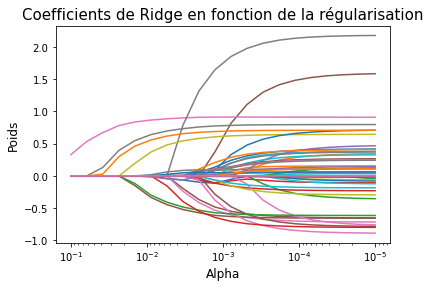

In [78]:
# Chemins de regularisation pour observer l'évolution des coefficients en fonction des valeurs alpha durant la GridSearchCV

# Calculer les chemins
lasso2 = Lasso(max_iter=5000)

n_alphas = 20
alphas = np.logspace(-5, -1, n_alphas)

coefs = []
errors = []
for a in alphas:
    lasso2.set_params(alpha=a)
    lasso2.fit(X_train_imp, y_emission_train_norm)
    coefs.append(lasso2.coef_)
    errors.append(np.mean((lasso2.predict(X_test_imp) - y_emission_test_norm) ** 2))
    
# On recrée un array numpy à deux dimmension pour le plot
coefs = np.array(coefs).reshape(n_alphas, -1)

# Visualiser les chemins
plt.figure(figsize=(6, 4))

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.title('Coefficients de Ridge en fonction de la régularisation', fontsize=15)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('Poids', fontsize=12)


plt.axis('tight')
plt.show()

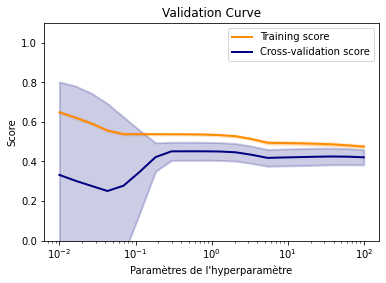

In [67]:
# Validation curve
val_curve(Lasso(),
          X_train_imp,
          y_energy_train_norm,
          "alpha",
          np.logspace(-2, 2, 20))

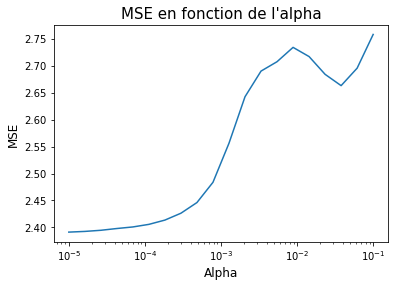

In [68]:
plt.figure(figsize=(6, 4))

ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')

plt.title("MSE en fonction de l'alpha", fontsize=15)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.show()

# Support Vector Regression

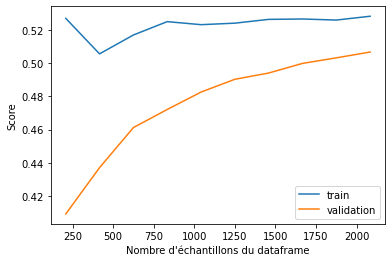

In [69]:
# Learning curve
learn_curve(SVR(), X_train_imp, y_emission_train_norm)

In [77]:
grid_svr2 =  GridSearchCV(estimator=pipeline_svr, 
                              param_grid=param3,
                              scoring='r2',
                              cv=5)

start_grid7 = time.time()
grid_svr2.fit(X_train_imp[:100], y_emission_train_norm[:100])
stop_grid7 = time.time()

vitesse_svr_grid2 = stop_grid7-start_grid7
print("Durée de pour l'optimisation (en sec):", vitesse_svr_grid2)

Durée de pour l'optimisation (en sec): 2540.4914565086365


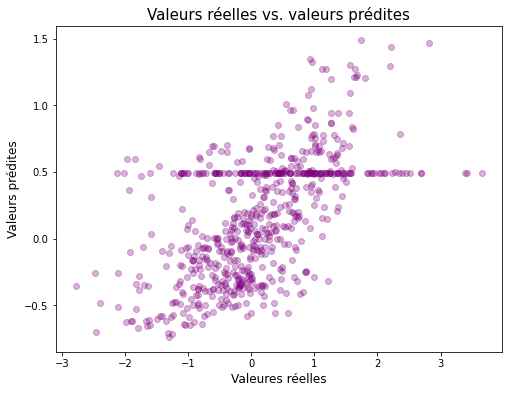

In [90]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred7 = grid_svr2.predict(X_test_imp)
plt.scatter(y_emission_test_norm, y_pred7, color='purple', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [80]:
# Afficher les hyperparamètres optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_svr2.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_svr2.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__C': 1.0, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__C,param_regressor__gamma,param_regressor__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
53,0.001601,4.903498e-04,0.000400,0.000490,1.0,0.01,rbf,"{'regressor__C': 1.0, 'regressor__gamma': 0.01...",0.441279,0.264214,0.237033,0.313450,-0.014971,0.248201,0.149116,1
65,0.002000,6.329407e-04,0.000794,0.000397,4.641589,0.001,rbf,"{'regressor__C': 4.6415888336127775, 'regresso...",0.587944,0.506484,-0.115711,0.339432,-0.276366,0.208357,0.343547,2
0,0.002000,5.309834e-07,0.000203,0.000406,0.01,0.0001,linear,"{'regressor__C': 0.01, 'regressor__gamma': 0.0...",0.517789,0.665873,-0.438817,0.307526,-0.070266,0.196421,0.402655,3
12,0.000998,7.412326e-06,0.000600,0.000490,0.01,1.0,linear,"{'regressor__C': 0.01, 'regressor__gamma': 1.0...",0.517789,0.665873,-0.438817,0.307526,-0.070266,0.196421,0.402655,3
3,0.001001,1.689915e-06,0.000400,0.000490,0.01,0.001,linear,"{'regressor__C': 0.01, 'regressor__gamma': 0.0...",0.517789,0.665873,-0.438817,0.307526,-0.070266,0.196421,0.402655,3


#### Métriques

In [82]:
# Modèles avec les meilleurs hyperparamètres
svr2 = SVR(C=1.0,
         gamma=0.01,
         kernel='rbf')


# Moyenne d'une cross validation avec comme score mean_squared_error
mse_mean_svr2 = cross_val_score(svr2,
                                y_emission_test_norm, 
                                y_pred7,
                                cv =5,
                                scoring='neg_mean_squared_error').mean()

mse_mean_svr_pos2 = -1*mse_mean_svr2 # Rendre le résultat positif

# Root Mean Squared Error (RMSE)
rmse_svr2 = np.sqrt(metrics.mean_squared_error(y_emission_test_norm,
                                               y_pred7)
                   )

# Moyenne d'une cross validation avec comme score mean_absolute_error (MAE)
mae_mean_svr2 = cross_val_score(svr2, 
                                y_emission_test_norm, 
                                y_pred7, 
                                cv =5, 
                                scoring='neg_mean_absolute_error').mean()

mae_mean_svr_pos2 = -1*mae_mean_svr2 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_svr2 = cross_val_score(svr2,
                                  y_emission_test_norm,
                                  y_pred7, 
                                  cv =5, 
                                  scoring='neg_median_absolute_error').mean()

medae_mean_svr_pos2 = -1*medae_mean_svr2 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_svr2 = cross_val_score(svr2, 
                          X_train_imp,
                          y_emission_train_norm.ravel(), 
                          cv =5, 
                          scoring='r2').mean()

# Test score après optimisation
score_svr2 = grid_svr2.score(X_test_imp,
                            y_emission_test_norm)

print('MSE :', mse_mean_svr_pos2)
print("RMSE :", rmse_svr2)
print('MAE (Mean Absolute Error) :', mae_mean_svr_pos2)
print('MedAE(Median Absolute Error) :', medae_mean_svr_pos2)
print('R2 :', r2_svr2)
print('Test score après optimisation:', score_svr2)

MSE : 0.16980967498855443
RMSE : 0.8023697445997267
MAE (Mean Absolute Error) : 0.31762300248850633
MedAE(Median Absolute Error) : 0.25032707249673475
R2 : 0.3865520822873124
Test score après optimisation: 0.33968633338729204


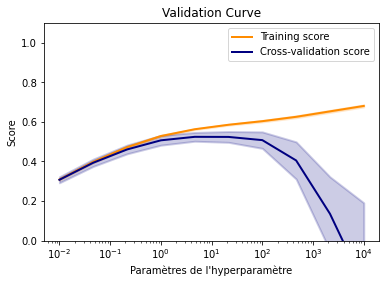

In [83]:
# Validation curve pour l'hyperparamètre 'C'
val_curve(SVR(),
          X_train_imp,
          y_emission_train_norm,
         'C',
          np.logspace(-2, 4, 10))

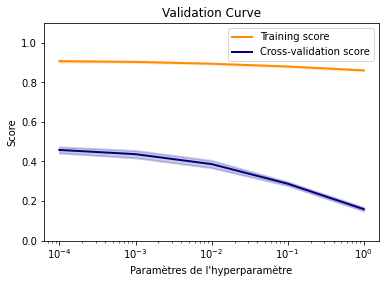

In [84]:
# Validation curve pour l'hyperparamètre 'gamma'
val_curve(SVR(),
          X_train_imp,
          y_emission_train_norm,
         'gamma',
          np.logspace(-4, 0, 5))

# Random Forest Regressor

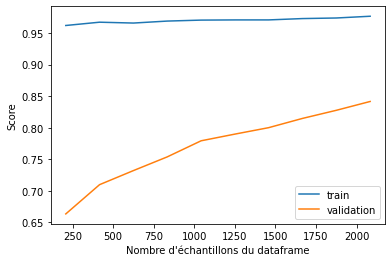

In [85]:
# Learning curve
learn_curve(RandomForestRegressor(), X_train_imp, y_energy_train_norm)

In [104]:
grid_rfreg2 = GridSearchCV(estimator=pipeline_rf,
                          param_grid=param4,
                          scoring='r2',
                          cv=5)

start_grid8 = time.time()
grid_rfreg2.fit(X_train_imp, y_emission_train_norm.ravel())
stop_grid8 = time.time()

vitesse_rf_grid2 = stop_grid8-start_grid8
print("Temps pour l'optimisation:", vitesse_rf_grid2)

Temps pour l'optimisation: 141.6511800289154


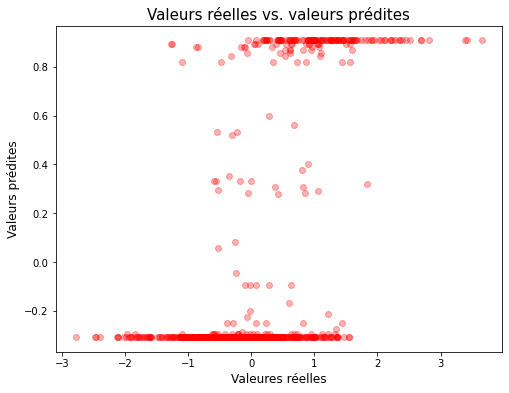

In [87]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred8 = grid_rfreg2.predict(X_test_imp)
plt.scatter(y_emission_test_norm, y_pred8, color='red', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [88]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_rfreg2.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_rfreg2.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__bootstrap': True, 'regressor__max_depth': 1, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__max_depth,param_regressor__max_features,param_regressor__min_samples_leaf,param_regressor__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
117,0.232194,0.039509,0.008200,0.000748,True,1,auto,1,2,"{'regressor__bootstrap': True, 'regressor__max...",0.289770,0.297187,0.281707,0.268884,0.290779,0.285665,0.009727,1
110,0.199985,0.003409,0.007414,0.000479,True,1,auto,0.1,8,"{'regressor__bootstrap': True, 'regressor__max...",0.289617,0.296270,0.280627,0.269717,0.290218,0.285290,0.009250,2
109,0.206810,0.007434,0.007997,0.000637,True,1,auto,0.1,4,"{'regressor__bootstrap': True, 'regressor__max...",0.288890,0.294886,0.281438,0.271737,0.288793,0.285149,0.007946,3
119,0.214204,0.015622,0.007989,0.000015,True,1,auto,1,8,"{'regressor__bootstrap': True, 'regressor__max...",0.288336,0.294173,0.282328,0.267432,0.293067,0.285067,0.009758,4
118,0.215214,0.003050,0.008391,0.000497,True,1,auto,1,4,"{'regressor__bootstrap': True, 'regressor__max...",0.285589,0.296314,0.281383,0.269694,0.290056,0.284607,0.008950,5


#### Métriques

In [132]:
rf2 = RandomForestRegressor(bootstrap=True,
                           max_depth=1,
                           max_features='auto', 
                           min_samples_leaf=1,
                           min_samples_split=2)

# Moyenne d'une cross validation avec comme score mean_squared_error
mse_mean_rf2 = cross_val_score(rf2,
                               X_train_imp,
                               y_emission_train_norm.ravel(),
                               cv =5,
                               scoring='neg_mean_squared_error').mean()

mse_mean_rf2_pos = -1*mse_mean_rf2 # Rendre le résultat positif

# Root Mean Squared Error (RMSE)
rmse_rf2 = np.sqrt(metrics.mean_squared_error(y_energy_test_norm,
                                              y_pred8)
                  )

# Moyenne d'une cross validation avec comme score mean_squared_error
mae_mean_rf2 = cross_val_score(rf2,
                               X_train_imp,
                               y_emission_train_norm.ravel(),
                               cv =5, 
                               scoring='neg_median_absolute_error').mean()

mae_mean_rf2_pos = -1*mae_mean_rf2 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_rf2 = cross_val_score(rf2,
                                 X_train_imp, 
                                 y_emission_train_norm.ravel(),
                                 cv =5, 
                                 scoring='neg_median_absolute_error').mean()

medae_mean_rf2_pos = -1*medae_mean_rf2 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_rf2 = cross_val_score(rf2,
                         X_train_imp,
                         y_emission_train_norm.ravel(),
                         cv =5,
                         scoring='r2')

# Test score après optimisation
score_rf2 = grid_rfreg2.score(X_test_imp,
                              y_emission_test_norm)

print('MSE :',mse_mean_rf2_pos)
print("RMSE :", rmse_rf2)
print('MAE (Mean Absolute Error) :', mae_mean_rf2_pos)
print('MedAE( Median Absolute Error) :', medae_mean_rf2_pos)
print('R2 :', r2_rf2)
print('Test score après optimisation:', score_rf2)

MSE : 0.7143107490841942
RMSE : 0.7446070352179864
MAE (Mean Absolute Error) : 0.5339126215391898
MedAE( Median Absolute Error) : 0.5357749284210586
R2 : [0.29204109 0.29630501 0.2860467  0.27031343 0.28425396]
Test score après optimisation: 0.30623295732599487


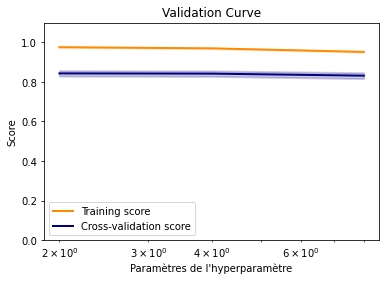

In [94]:
# Validation curve pour l'hyperparamètre 'min_samples_split'
val_curve(RandomForestRegressor(),
          X_train_imp,
          y_emission_train_norm,
          "min_samples_split",
          [2, 4, 8])

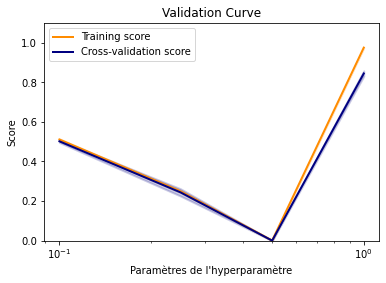

In [95]:
# Validation curve pour l'hyperparamètre 'min_samples_leaf'
val_curve(RandomForestRegressor(),
          X_train_imp,
          y_emission_train_norm,
          "min_samples_leaf",
          [0.1, 0.25, 0.5, 1])

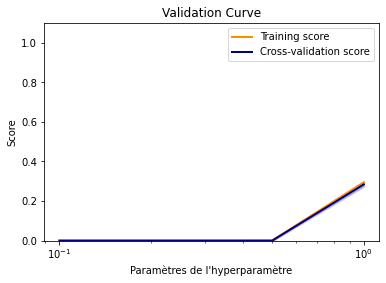

In [96]:
# Validation curve pour l'hyperparamètre 'max_depth'
val_curve(RandomForestRegressor(),
          X_train_imp,
          y_emission_train_norm,
          "max_depth",
          [0.1, 0.25, 0.5, 1])

In [97]:
## Comparaison des métriques pour les différents modèles 

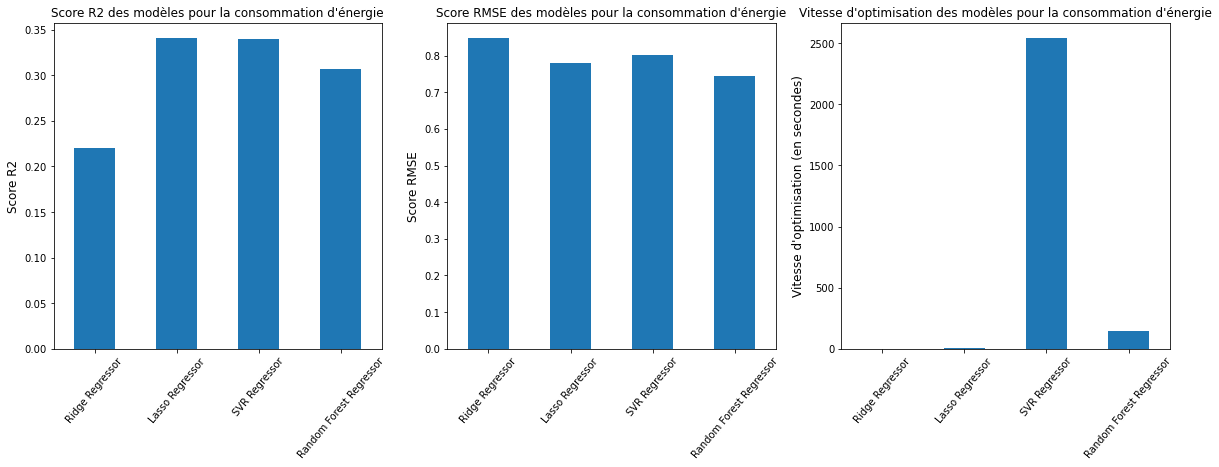

In [163]:
plt.figure(figsize=(20,6))

#Score R2 sur test set
plt.subplot(1, 3, 1)
score_model_2 = pd.Series([score_ridge2, score_lasso2, score_svr2, score_rf2], 
                        index=["Ridge Regressor", "Lasso Regressor", "SVR Regressor", 
                               "Random Forest Regressor"])
score_model_2.plot.bar()
plt.title("Score R2 des modèles pour la consommation d'énergie", fontsize=12)
plt.ylabel('Score R2', fontsize=12)
degrees = 50
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

# RMSE 
plt.subplot(1, 3, 2)
rmse_model_2 = pd.Series([rmse_ridge2, rmse_lasso2, rmse_svr2, rmse_rf2], 
                          index=["Ridge Regressor", "Lasso Regressor", "SVR Regressor", 
                                "Random Forest Regressor"])
rmse_model_2.plot.bar()
plt.title("Score RMSE des modèles pour la consommation d'énergie", fontsize=12)
plt.ylabel("Score RMSE", fontsize=12)
degrees = 50
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

# Vitesse optimisation
plt.subplot(1, 3, 3)
vitesse_model_optimisation_2 = pd.Series([vitesse_ridge_grid2, vitesse_lasso_grid2, 
                                          vitesse_svr_grid2, vitesse_rf_grid2], 
                                       index=["Ridge Regressor", "Lasso Regressor", "SVR Regressor",
                                             "Random Forest Regressor"])
vitesse_model_optimisation_2.plot.bar()
plt.title("Vitesse d'optimisation des modèles pour la consommation d'énergie", fontsize=12)
plt.ylabel("Vitesse d'optimisation (en secondes)", fontsize=12)
degrees = 50
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)


plt.show()

Features les plus importantes du Random Forest

In [ ]:
'''
df_rf2 = X_train.columns

df_features2 = pd.Series(rfreg2.feature_importances_, index = df_rf2)
df_features2 = df_features2.sort_values()

plt.figure(figsize=(20, 35))
plt.barh(df_rf2, df_features2)
plt.title('Importance des features pour le modèle Random Forest Regressor')
'''

Les 3 features les plus importantes sont :

- Hotel_GFA
- Bank Branch_GFA
- Data Center_GFA

# 4. Energystarscore
- Nous allons supprimer les lignes sur lesquelles il n'y a pas de valeurs pour les features de l'Energystarscore
- Nous allons refaire le preprocessing
- Nous allons prendre le meilleur modele identifié auparavant : le Random Forrest Regressor
- Nous allons faire des predictions avec ce modele avec et sans les features de l'Energystarscore
- Nous allons observer le gap au niveau de la prévision et de la durée et nous allons conclure sur l'utilité de l'Energystarscore

# 4.1. Suppression des lignes sans valeurs

In [106]:
df2 =  df[['EnergyStar_1st_q', 'EnergyStar_2nd_q', 'EnergyStar_3rd_q', 'EnergyStar_4th_q']]
df2.isna().mean()

EnergyStar_1st_q    0.0
EnergyStar_2nd_q    0.0
EnergyStar_3rd_q    0.0
EnergyStar_4th_q    0.0
dtype: float64

In [107]:
df2.shape

(3258, 4)

In [108]:
row_values = df2.apply(sum, axis=1) 
df = df.loc[row_values == 1, :]
df.shape

(2200, 119)

Nous avons retiré 1058 lignes du dataframe

# 4.2. Nouveau preprocessing

##### Train_test_split

In [109]:
y_energy2 = df['SiteEnergyUse(kBtu)']
y_emission2 = df['TotalGHGEmissions']
x2 = df.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'],axis = 1)

In [110]:
X_train2, X_test2, y_emission_train2, y_emission_test2 = train_test_split(x2, y_emission2, test_size = 0.2)

print('Train set:', X_train2.shape)
print('Test set:', X_test2.shape)

Train set: (1760, 117)
Test set: (440, 117)


#####  Tranformation Gaussienne

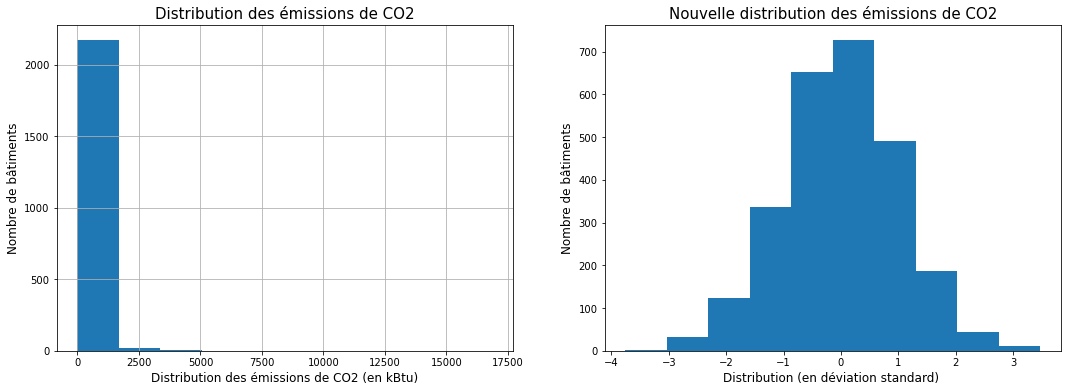

In [151]:
plt.figure(figsize=(18, 6))

# Transformation gaussienne de la feature basée sur les émissions d'énergie
plt.subplot(1, 2, 1)
y_emission2.hist()

plt.title("Distribution des émissions de CO2", fontsize=15 ) 
plt.xlabel('Distribution des émissions de CO2 (en kBtu)', fontsize= 12) 
plt.ylabel('Nombre de bâtiments', fontsize=12) 

# Utilisation de la méthode yeo-johnson car la méthode box-cox n'acceptaient pas les valeurs négatives 
plt.subplot(1, 2, 2)

pt3 = PowerTransformer(method='yeo-johnson')
y_emission_train_norm2 = pt3.fit_transform(y_emission_train.values.reshape(-1, 1)) 
plt.hist(y_emission_train_norm)

plt.title('Nouvelle distribution des émissions de CO2', fontsize=15) 
plt.xlabel('Distribution (en déviation standard) ', fontsize=12) 
plt.ylabel('Nombre de bâtiments', fontsize=12) 

plt.show()

#####  Standard caling

In [116]:
X_train2.values

array([[1.0000e+00, 1.0000e+00, 3.8582e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 5.0000e+00, 4.0552e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.0000e+00, 2.2000e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 1.0000e+01, 6.3409e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.0000e+00, 2.7553e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 2.0000e+00, 6.7235e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [117]:
# Fit_transorm sur le train puis un transform sur le test.
scaler2 = StandardScaler()
X_train_std2 = scaler2.fit_transform(X_train2)
X_test_std2 = scaler2.transform(X_test2)

#####  Imputation des NAN

In [118]:
imputer2 = SimpleImputer(missing_values = np.nan, strategy='mean')
X_train_imp2 = imputer2.fit_transform(X_train_std2)

In [141]:
X_test_imp2 = imputer2.transform(X_test_std2)

# 4.3. Prediction via le Random Forest Regressor pour la feature 'TotalGHGEmissions'

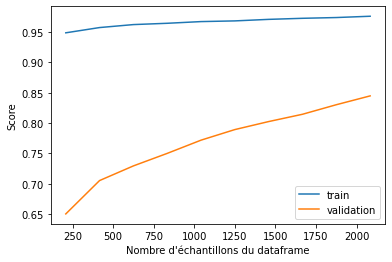

In [120]:
# Learning curve
learn_curve(RandomForestRegressor(), X_train_imp, y_emission_train_norm)

In [162]:
grid_rfreg3 = GridSearchCV(estimator=pipeline_rf,
                          param_grid=param4,
                          scoring='r2',
                          cv=5)

start_grid9 = time.time()
grid_rfreg3.fit(X_train_imp, y_emission_train_norm.ravel())
stop_grid9 = time.time()

vitesse_rf_grid3 = stop_grid9-start_grid9
print("Temps pour l'optimisation:", vitesse_rf_grid3)

Temps pour l'optimisation: 136.0725600719452


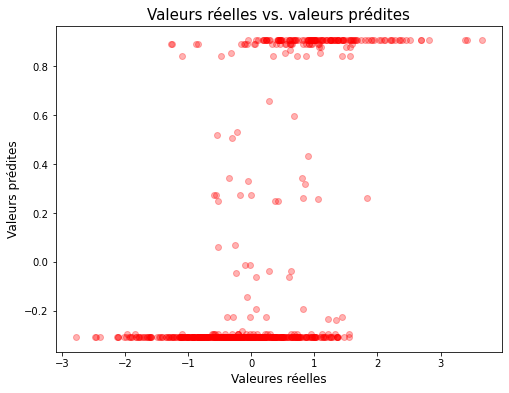

In [122]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred9 = grid_rfreg3.predict(X_test_imp)
plt.scatter(y_emission_test_norm, y_pred9, color='red', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

In [123]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:", grid_rfreg3.best_params_)

# Affichage des métriques
result = pd.DataFrame(grid_rfreg3.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'regressor__bootstrap': True, 'regressor__max_depth': 1, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 0.1, 'regressor__min_samples_split': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__max_depth,param_regressor__max_features,param_regressor__min_samples_leaf,param_regressor__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
108,0.207015,0.003012,0.007792,0.000416,True,1,auto,0.1,2,"{'regressor__bootstrap': True, 'regressor__max...",0.293357,0.294836,0.284740,0.267353,0.287958,0.285649,0.009846,1
117,0.219581,0.009119,0.007814,0.000391,True,1,auto,1,2,"{'regressor__bootstrap': True, 'regressor__max...",0.291067,0.294080,0.281944,0.267576,0.289654,0.284864,0.009526,2
119,0.223886,0.022113,0.009193,0.002487,True,1,auto,1,8,"{'regressor__bootstrap': True, 'regressor__max...",0.286943,0.294456,0.279984,0.267267,0.294358,0.284602,0.010194,3
109,0.211792,0.006472,0.008008,0.000014,True,1,auto,0.1,4,"{'regressor__bootstrap': True, 'regressor__max...",0.289155,0.295723,0.282305,0.269860,0.285286,0.284466,0.008572,4
110,0.205408,0.002487,0.007794,0.000397,True,1,auto,0.1,8,"{'regressor__bootstrap': True, 'regressor__max...",0.290547,0.293595,0.280072,0.268918,0.286130,0.283852,0.008744,5


#### Métriques

In [136]:
rf3 = RandomForestRegressor(bootstrap=True,
                           max_depth=1,
                           max_features='auto', 
                           min_samples_leaf=0.1,
                           min_samples_split=2)

# Moyenne d'une cross validation avec comme score mean_squared_error
mse_mean_rf3 = cross_val_score(rf3,
                               X_train_imp,
                               y_emission_train_norm.ravel(),
                               cv =5,
                               scoring='neg_mean_squared_error').mean()

mse_mean_rf3_pos = -1*mse_mean_rf3 # Rendre le résultat positif

# Root Mean Squared Error (RMSE)
rmse_rf3 = np.sqrt(metrics.mean_squared_error(y_energy_test_norm,
                                              y_pred8)
                  )

# Moyenne d'une cross validation avec comme score mean_squared_error
mae_mean_rf3 = cross_val_score(rf3,
                               X_train_imp,
                               y_emission_train_norm.ravel(),
                               cv =5, 
                               scoring='neg_median_absolute_error').mean()

mae_mean_rf3_pos = -1*mae_mean_rf3 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_rf3 = cross_val_score(rf3,
                                 X_train_imp, 
                                 y_emission_train_norm.ravel(),
                                 cv =5, 
                                 scoring='neg_median_absolute_error').mean()

medae_mean_rf3_pos = -1*medae_mean_rf3 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_rf3 = cross_val_score(rf3,
                         X_train_imp,
                         y_emission_train_norm.ravel(),
                         cv =5,
                         scoring='r2')

# Test score après optimisation
score_rf3 = grid_rfreg2.score(X_test_imp,
                              y_emission_test_norm)

print('MSE :',mse_mean_rf3_pos)
print("RMSE :", rmse_rf3)
print('MAE (Mean Absolute Error) :', mae_mean_rf3_pos)
print('MedAE( Median Absolute Error) :', medae_mean_rf3_pos)
print('R2 :', r2_rf3)
print('Test score après optimisation:', score_rf3)

MSE : 0.715270511492829
RMSE : 0.7446070352179864
MAE (Mean Absolute Error) : 0.533196579118947
MedAE( Median Absolute Error) : 0.5338297395406302
R2 : [0.28792911 0.2943734  0.28012484 0.26913254 0.28872015]
Test score après optimisation: 0.30623295732599487


In [ ]:
X_train_imp2, y_emission_train_norm2.ravel()
X_test_imp2, y_emission_test_norm2.ravel() 

Le meilleur score R2 pour Random Forest Regressor est de 0.896 sur le test set avec les hyperparamètres de base.

# 4.4. Prediction via le Random Forrest Regressor sans les 4 colonnes tirées de Energystarscore

In [138]:
df.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'Electricity_in_bat', 'Gas_in_bat', 'Steam_in_bat',
       ...
       'Repair Services (Vehicle, Shoe, Locksmith, etc)_GFA',
       'Other - Education_GFA', 'Urgent Care/Clinic/Other Outpatient_GFA',
       'Residence Hall/Dormitory_GFA', 'Financial Office_GFA',
       'Retail Store_GFA', 'Lifestyle Center_GFA', 'Adult Education_GFA',
       'Fast Food Restaurant_GFA', 'Movie Theater_GFA'],
      dtype='object', length=119)

In [139]:
col_name_remove = ['EnergyStar_1st_q', 'EnergyStar_2nd_q', 'EnergyStar_3rd_q', 'EnergyStar_4th_q']
id_to_remove = [df.columns.get_loc(c) for c in col_name_remove]
id_to_remove

[50, 51, 52, 53]

In [142]:
# Retire certaines colonnes du numpy array d'après leurs index
X_train_imp2_less = np.delete(X_train_imp2, id_to_remove, axis=1)
X_test_imp2_less = np.delete(X_test_imp2, id_to_remove, axis=1)
X_train_imp2_less.shape

(1760, 113)

In [155]:
grid_rfreg4 = GridSearchCV(estimator=pipeline_rf,
                          param_grid=param4,
                          scoring='r2',
                          cv=5)

start_grid10 = time.time()
grid_rfreg4.fit(X_train_imp, y_emission_train_norm2.ravel())
stop_grid10 = time.time()

vitesse_rf_grid4 = stop_grid10-start_grid10
print("Temps pour l'optimisation:", vitesse_rf_grid4)

Temps pour l'optimisation: 140.15807056427002


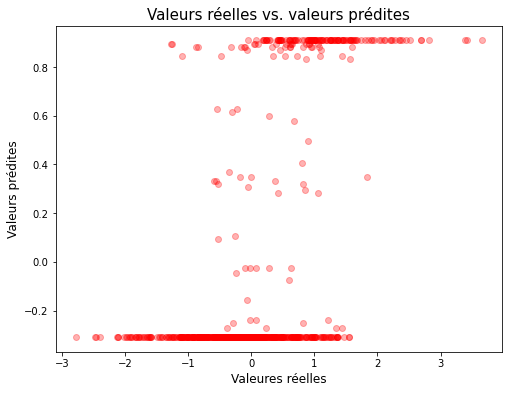

In [156]:
# Application du modele sur le test set

plt.figure(figsize=(8, 6))
y_pred10 = grid_rfreg4.predict(X_test_imp)
plt.scatter(y_emission_test_norm, y_pred10, color='red', alpha=0.3)

plt.title('Valeurs réelles vs. valeurs prédites', fontsize=15) 
plt.xlabel('Valeures réelles', fontsize=12) 
plt.ylabel('Valeurs prédites', fontsize=12) 

plt.show()

#### Métriques

In [158]:
rf4 = RandomForestRegressor(bootstrap=True,
                           max_depth=2,
                           max_features='auto', 
                           min_samples_leaf=1,
                           min_samples_split=10)

# Moyenne d'une cross validation avec comme score mean_squared_error
mse_mean_rf4 = cross_val_score(rf4,
                               X_train_imp,
                               y_emission_train_norm.ravel(),
                               cv =5,
                               scoring='neg_mean_squared_error').mean()

mse_mean_rf4_pos = -1*mse_mean_rf4 # Rendre le résultat positif

# Root Mean Squared Error (RMSE)
rmse_rf4 = np.sqrt(metrics.mean_squared_error(y_energy_test_norm,
                                              y_pred8)
                  )

# Moyenne d'une cross validation avec comme score mean_squared_error
mae_mean_rf4 = cross_val_score(rf4,
                               X_train_imp,
                               y_emission_train_norm.ravel(),
                               cv =5, 
                               scoring='neg_median_absolute_error').mean()

mae_mean_rf4_pos = -1*mae_mean_rf4 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score mean_squared_error (MedAE)
medae_mean_rf4 = cross_val_score(rf4,
                                 X_train_imp, 
                                 y_emission_train_norm.ravel(),
                                 cv =5, 
                                 scoring='neg_median_absolute_error').mean()

medae_mean_rf4_pos = -1*medae_mean_rf4 # Rendre le résultat positif

# Moyenne d'une cross validation avec comme score R2
r2_rf4 = cross_val_score(rf4,
                         X_train_imp,
                         y_emission_train_norm.ravel(),
                         cv =5,
                         scoring='r2')

# Test score après optimisation
score_rf4 = grid_rfreg4.score(X_test_imp,
                              y_emission_test_norm)

print('MSE :',mse_mean_rf4_pos)
print("RMSE :", rmse_rf4)
print('MAE (Mean Absolute Error) :', mae_mean_rf4_pos)
print('MedAE( Median Absolute Error) :', medae_mean_rf4_pos)
print('R2 :', r2_rf4)
print('Test score après optimisation:', score_rf4)

MSE : 0.4911475698748761
RMSE : 0.7446070352179864
MAE (Mean Absolute Error) : 0.45638597256489605
MedAE( Median Absolute Error) : 0.4551124651723212
R2 : [0.51261433 0.50255211 0.51620052 0.49891816 0.51300642]
Test score après optimisation: 0.30522159038495944


# 5. Résultat des modèles et durée

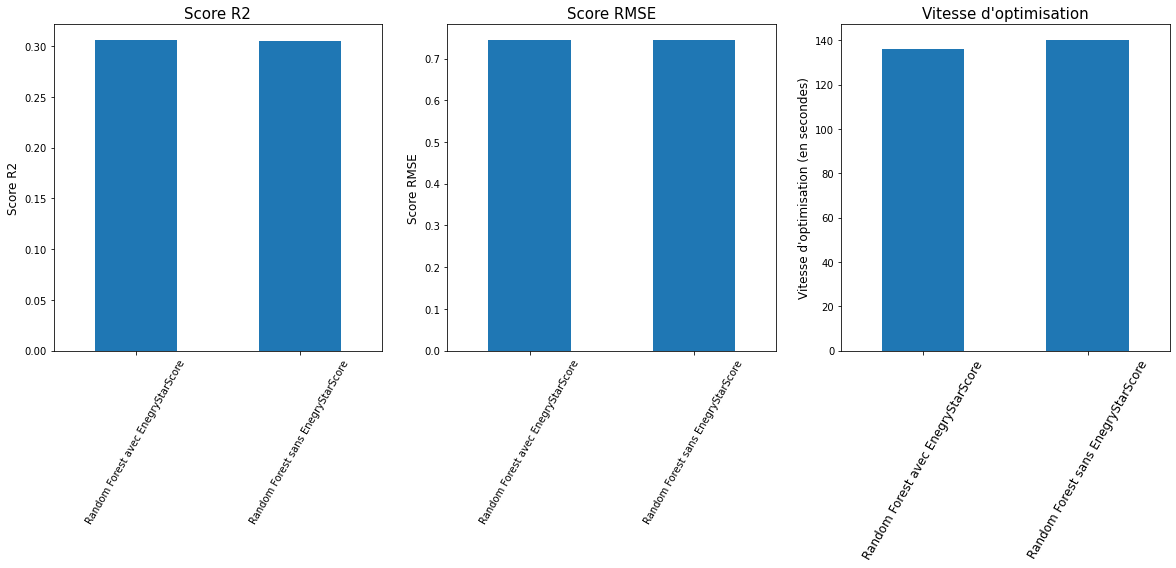

In [167]:
plt.figure(figsize=(20,6))

# Score R2
plt.subplot(1, 3, 1)
score_model_3 = pd.Series([score_rf3, score_rf4], 
                        index=["Random Forest avec EnegryStarScore",
                              "Random Forest sans EnegryStarScore"])
score_model_3.plot.bar()
plt.title("Score R2", fontsize=15)
plt.ylabel('Score R2', fontsize=12)
degrees = 60
plt.xticks(rotation=degrees, fontsize=10)

# RMSE
plt.subplot(1, 3, 2)
rmse_model_3 = pd.Series([rmse_rf3, rmse_rf4], 
                          index=["Random Forest avec EnegryStarScore",
                              "Random Forest sans EnegryStarScore"])
rmse_model_3.plot.bar()
plt.title("Score RMSE", fontsize=15)
plt.ylabel("Score RMSE", fontsize=12)
degrees = 60
plt.xticks(rotation=degrees, fontsize=10)

# Vitesse optimisation
plt.subplot(1, 3, 3)
vitesse_model_optimisation_2 = pd.Series([vitesse_rf_grid3, vitesse_rf_grid4], 
                                       index=["Random Forest avec EnegryStarScore",
                              "Random Forest sans EnegryStarScore"])
vitesse_model_optimisation_2.plot.bar()
plt.title("Vitesse d'optimisation", fontsize=15)
plt.ylabel("Vitesse d'optimisation (en secondes)", fontsize=12)
degrees = 60
plt.xticks(rotation=degrees, fontsize=12)

plt.show()

# 6. Conclusion sur l'EnergyStarScore

- La différence entre avec et sans les 4 features tirés de l'EnergyStarScore est très faible (0.870 avec et 0.872 sans). 
- Une si faible différence, de plus défavorable à cette feature ne justifie pas l'utilisation de l'EnergyStarScore, étant donné le coût et la difficulté à se procurer ces données.

## Pipeline finale pour mise en production

In [168]:
# Pipeline finale
reg = RandomForestRegressor(bootstrap=True,
                           max_depth=2,
                           max_features='auto', 
                           min_samples_leaf=1,
                           min_samples_split=10)

pipe_rf = Pipeline([('scale', StandardScaler()),
                        ('regressor', reg)]
                      )

In [169]:
# Enregistrement du modèle pour la mise en production
joblib.dump(pipe_rf, 'model_elec_final.plk')

['model_elec_final.plk']